import 套件

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

load MNIST dataset

In [ ]:
def load_reduced_mnist(num_samples=1000):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    reduced_indices = indices[:num_samples]
    reduced_dataset = Subset(dataset, reduced_indices)
    return DataLoader(reduced_dataset, batch_size=32, shuffle=True)

# Loading the MNIST dataset
dataloader = load_reduced_mnist(num_samples=10000)

# Example target image
target_image, _ = next(iter(dataloader))
target_image = target_image[0].unsqueeze(0)

DIP model

In [3]:
# Define the DIP model
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# DIP training function
def train_dip(dip_model, target_image, epochs=10, lr=1e-3):
    optimizer = optim.Adam(dip_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
      optimizer.zero_grad()
      noise = torch.randn_like(target_image)
      noise_image = target_image + noise
      restore_image = dip_model(noise_image)
      loss = criterion(restore_image,target_image)
      # loss = criterion(output, target_image)
      loss.backward()
      optimizer.step()
      if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, DIP Loss: {loss.item()}')

    return dip_model

DDPM model

In [4]:
# Define the DDPM model
class DDPMModel(nn.Module):
    def __init__(self):
        super(DDPMModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
# DDPM 訓練函數
def train_ddpm(ddpm_model, dataloader, epochs=10, lr=1e-3, alpha_t=0.9):
    optimizer = optim.Adam(ddpm_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for images, _ in tqdm(dataloader):
            optimizer.zero_grad()
            noisy_images, noise = forward_diffusion(images, alpha_t)
            # 模型預測添加的噪音
            predicted_noise = ddpm_model(noisy_images)
            # 計算預測噪音與實際噪音之間的損失
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, DDPM Loss: {loss.item()}')

    return ddpm_model


Integrate model

In [5]:
# Define the Integrate model
# 定義整合模型
class IntegrateModel(nn.Module):
    def __init__(self, dip_model, ddpm_model):
        super(IntegrateModel, self).__init__()
        self.dip_model = dip_model
        self.ddpm_model = ddpm_model

    def forward(self, x, alpha_t=0.9):
        noisy_images, _ = forward_diffusion(x, alpha_t)
        restored_images = self.dip_model(noisy_images)
        generated_images = reverse_diffusion(self.ddpm_model, restored_images, alpha_t)
        return generated_images
# 訓練整合模型
def train_integrate(dip_model, ddpm_model, dataloader, epochs=10, lr=1e-3, alpha_t=0.9):
    optimizer = optim.Adam(ddpm_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for images, _ in tqdm(dataloader):
            optimizer.zero_grad()
            noisy_images, noise = forward_diffusion(images, alpha_t)
            restore_images = dip_model(noisy_images)
            alpha_t_tensor = torch.tensor(alpha_t, dtype=torch.float32, device=noisy_images.device)
            alpha_t_tensor = alpha_t_tensor.expand_as(noisy_images)
            predicted_noise = ddpm_model(noisy_images)
            intergrate_image = (noisy_images - torch.sqrt(1 - alpha_t_tensor) * predicted_noise) / torch.sqrt(alpha_t_tensor)
            # predicted_noise = ddpm_model(restore_images)
            # loss = criterion(predicted_noise, torch.zeros_like(predicted_noise))
            loss = criterion(intergrate_image,images)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, integrate Loss: {loss.item()}')

    return ddpm_model

forward_diffusion是用來把圖片加入雜訊

In [6]:
# 前向擴散過程
def forward_diffusion(x, alpha_t):
    noise = torch.randn_like(x)
    alpha_t_tensor = torch.tensor(alpha_t, dtype=torch.float32, device=x.device)
    noisy_images = torch.sqrt(alpha_t_tensor) * x + torch.sqrt(1 - alpha_t_tensor) * noise
    return noisy_images, noise


reverse diffusion是用來生成圖片

In [7]:
# 定義反向擴散過程
def reverse_diffusion(ddpm_model, noisy_images, alpha_t):
    alpha_t_tensor = torch.tensor(alpha_t, dtype=torch.float32, device=noisy_images.device)
    alpha_t_tensor = alpha_t_tensor.expand_as(noisy_images)
    with torch.no_grad():
        predicted_noise = ddpm_model(noisy_images)
        generated_data = (noisy_images - torch.sqrt(1 - alpha_t_tensor) * predicted_noise) / torch.sqrt(alpha_t_tensor)
    return generated_data


初始化model

In [8]:
# Instantiate models
dip_model = DIPModel()
ddpm_model = DDPMModel()
integrated_model = IntegrateModel(dip_model, ddpm_model)

開始訓練

In [9]:
# Train DIP model
trained_dip = train_dip(dip_model, target_image, epochs=100)


Epoch 1/100, DIP Loss: 0.7189186811447144
Epoch 11/100, DIP Loss: 0.1509806215763092
Epoch 21/100, DIP Loss: 0.1449800282716751
Epoch 31/100, DIP Loss: 0.09889227151870728
Epoch 41/100, DIP Loss: 0.08104608952999115
Epoch 51/100, DIP Loss: 0.08729540556669235
Epoch 61/100, DIP Loss: 0.0768495500087738
Epoch 71/100, DIP Loss: 0.07440047711133957
Epoch 81/100, DIP Loss: 0.06799503415822983
Epoch 91/100, DIP Loss: 0.06668253988027573


In [ ]:
# Train integrate model
trained_integrate = train_integrate(trained_dip,ddpm_model, dataloader, 5,1e-3, 0.7)

In [12]:
# Train DDPM
trained_ddpm = train_ddpm(ddpm_model, dataloader, epochs=50, lr=1e-3, alpha_t=0.7)

100%|██████████| 313/313 [00:53<00:00,  5.89it/s]


Epoch 1, DDPM Loss: 0.057841431349515915


100%|██████████| 313/313 [00:56<00:00,  5.50it/s]


Epoch 2, DDPM Loss: 0.05240217596292496


100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


Epoch 3, DDPM Loss: 0.05658581480383873


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 4, DDPM Loss: 0.05295637995004654


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 5, DDPM Loss: 0.05466880649328232


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 6, DDPM Loss: 0.056276146322488785


100%|██████████| 313/313 [00:53<00:00,  5.87it/s]


Epoch 7, DDPM Loss: 0.049300022423267365


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 8, DDPM Loss: 0.04764441400766373


100%|██████████| 313/313 [00:53<00:00,  5.88it/s]


Epoch 9, DDPM Loss: 0.054147008806467056


100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


Epoch 10, DDPM Loss: 0.05210944265127182


100%|██████████| 313/313 [00:53<00:00,  5.86it/s]


Epoch 11, DDPM Loss: 0.05446700006723404


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 12, DDPM Loss: 0.05417593568563461


100%|██████████| 313/313 [00:56<00:00,  5.52it/s]


Epoch 13, DDPM Loss: 0.056544993072748184


100%|██████████| 313/313 [00:53<00:00,  5.88it/s]


Epoch 14, DDPM Loss: 0.05033213645219803


100%|██████████| 313/313 [00:53<00:00,  5.86it/s]


Epoch 15, DDPM Loss: 0.05091355741024017


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 16, DDPM Loss: 0.0552157424390316


100%|██████████| 313/313 [00:53<00:00,  5.80it/s]


Epoch 17, DDPM Loss: 0.05664903670549393


100%|██████████| 313/313 [00:54<00:00,  5.77it/s]


Epoch 18, DDPM Loss: 0.05369525030255318


100%|██████████| 313/313 [00:54<00:00,  5.73it/s]


Epoch 19, DDPM Loss: 0.05190286040306091


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 20, DDPM Loss: 0.045821160078048706


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 21, DDPM Loss: 0.052169039845466614


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 22, DDPM Loss: 0.04658733680844307


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 23, DDPM Loss: 0.055202990770339966


100%|██████████| 313/313 [00:54<00:00,  5.76it/s]


Epoch 24, DDPM Loss: 0.05223468318581581


100%|██████████| 313/313 [00:56<00:00,  5.56it/s]


Epoch 25, DDPM Loss: 0.044181011617183685


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 26, DDPM Loss: 0.05163321644067764


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 27, DDPM Loss: 0.052020713686943054


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 28, DDPM Loss: 0.049469124525785446


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 29, DDPM Loss: 0.04665837064385414


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 30, DDPM Loss: 0.047447215765714645


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 31, DDPM Loss: 0.047015074640512466


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 32, DDPM Loss: 0.0507647879421711


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 33, DDPM Loss: 0.054226987063884735


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 34, DDPM Loss: 0.05209696665406227


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 35, DDPM Loss: 0.05211230367422104


100%|██████████| 313/313 [00:54<00:00,  5.79it/s]


Epoch 36, DDPM Loss: 0.05125076323747635


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 37, DDPM Loss: 0.050301969051361084


100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


Epoch 38, DDPM Loss: 0.04800759628415108


100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


Epoch 39, DDPM Loss: 0.05826471745967865


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 40, DDPM Loss: 0.048786286264657974


100%|██████████| 313/313 [00:54<00:00,  5.80it/s]


Epoch 41, DDPM Loss: 0.05274832993745804


100%|██████████| 313/313 [00:53<00:00,  5.81it/s]


Epoch 42, DDPM Loss: 0.05854785069823265


100%|██████████| 313/313 [00:53<00:00,  5.86it/s]


Epoch 43, DDPM Loss: 0.04637378081679344


100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


Epoch 44, DDPM Loss: 0.057150207459926605


100%|██████████| 313/313 [00:53<00:00,  5.80it/s]


Epoch 45, DDPM Loss: 0.053169459104537964


100%|██████████| 313/313 [00:53<00:00,  5.82it/s]


Epoch 46, DDPM Loss: 0.04798777401447296


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 47, DDPM Loss: 0.058734796941280365


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch 48, DDPM Loss: 0.05602602660655975


100%|██████████| 313/313 [00:53<00:00,  5.81it/s]


Epoch 49, DDPM Loss: 0.04994703829288483


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]

Epoch 50, DDPM Loss: 0.045322198420763016


In [13]:
def visualize_images(target_image_np, generated_image_np, title):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(target_image_np, cmap='gray')
    plt.title('Target Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(generated_image_np, cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

In [14]:
# 產生測試圖片
test_images, _ = next(iter(dataloader))
noisy_test_images, _ = forward_diffusion(test_images, 0.7)


In [15]:
# integrate model 生成圖片
intergrate_image2 = reverse_diffusion(trained_integrate, noisy_test_images, 0.7)

In [16]:
# DDPM 生成圖片
generated_images = reverse_diffusion(trained_ddpm, noisy_test_images, 0.7)
# DIP 生成圖片(修復雜訊)
dip_image = trained_dip(noisy_test_images)
# 用DIP生成的圖片送給DDPM來生成圖片
intergrate_image = reverse_diffusion(trained_ddpm, dip_image, 0.7)


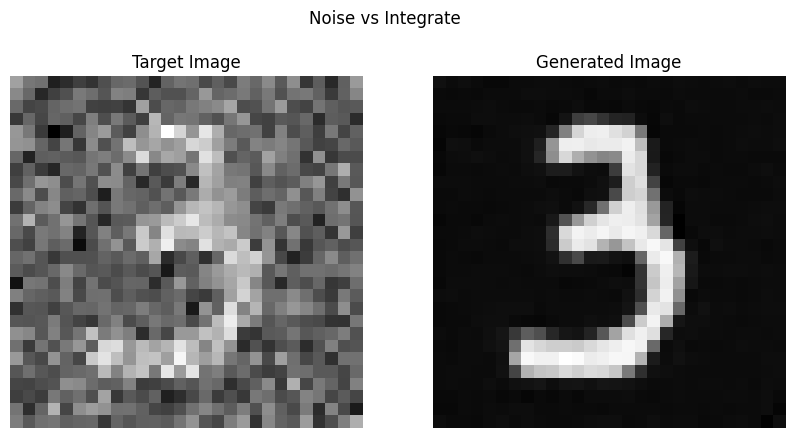

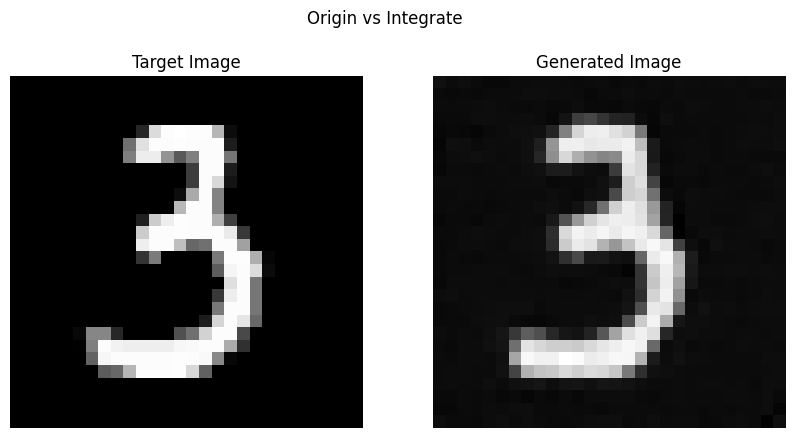

In [17]:
visualize_images(noisy_test_images[0].squeeze().detach().cpu().numpy(), intergrate_image2[0].squeeze().detach().cpu().numpy(), 'Noise vs Integrate')
visualize_images(test_images[0].squeeze().detach().cpu().numpy(), intergrate_image2[0].squeeze().detach().cpu().numpy(), 'Origin vs Integrate')


計算PSNR和SSIM

In [18]:
psnr_dip = psnr(test_images[0].squeeze().detach().cpu().numpy(), intergrate_image2[0].squeeze().detach().cpu().numpy())
ssim_dip = ssim(test_images[0].squeeze().detach().cpu().numpy(), intergrate_image2[0].squeeze().detach().cpu().numpy())
print(f'Integrate PSNR: {psnr_dip}, SSIM: {ssim_dip}')

Integrate PSNR: 22.615236886263656, SSIM: 0.8996644555668015


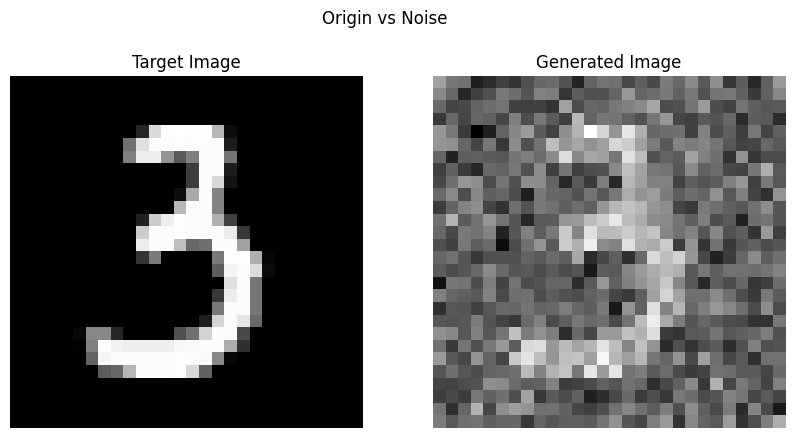

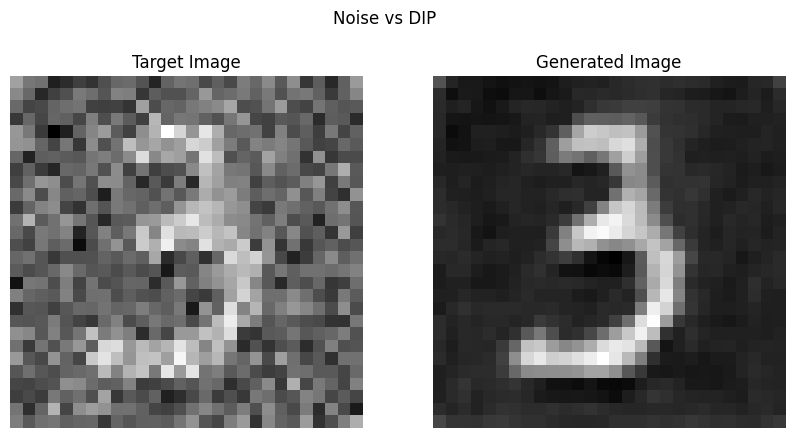

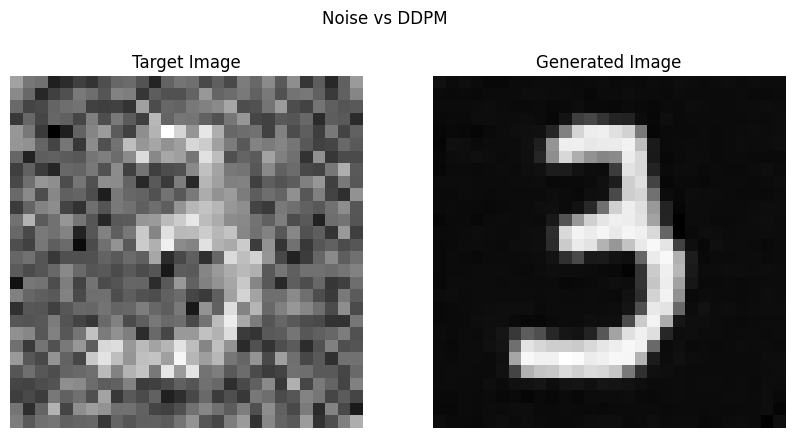

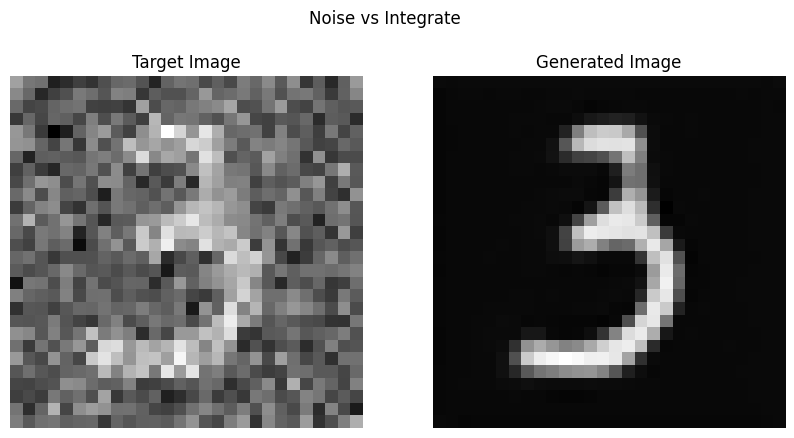

In [19]:
visualize_images(test_images[0].squeeze().detach().cpu().numpy(),noisy_test_images[0].squeeze().detach().cpu().numpy(), 'Origin vs Noise')
visualize_images(noisy_test_images[0].squeeze().detach().cpu().numpy(), dip_image[0].squeeze().detach().cpu().numpy(), 'Noise vs DIP')
visualize_images(noisy_test_images[0].squeeze().detach().cpu().numpy(), generated_images[0].squeeze().detach().cpu().numpy(), 'Noise vs DDPM')
visualize_images(noisy_test_images[0].squeeze().detach().cpu().numpy(), intergrate_image[0].squeeze().detach().cpu().numpy(), 'Noise vs Integrate')


In [20]:
psnr_dip = psnr(test_images[0].squeeze().detach().cpu().numpy(), dip_image[0].squeeze().detach().cpu().numpy())
ssim_dip = ssim(test_images[0].squeeze().detach().cpu().numpy(), dip_image[0].squeeze().detach().cpu().numpy())
print(f'Standalone DIP PSNR: {psnr_dip}, SSIM: {ssim_dip}')
psnr_dip = psnr(test_images[0].squeeze().detach().cpu().numpy(), generated_images[0].squeeze().detach().cpu().numpy())
ssim_dip = ssim(test_images[0].squeeze().detach().cpu().numpy(), generated_images[0].squeeze().detach().cpu().numpy())
print(f'Standalone DDPM PSNR: {psnr_dip}, SSIM: {ssim_dip}')
psnr_dip = psnr(test_images[0].squeeze().detach().cpu().numpy(), intergrate_image[0].squeeze().detach().cpu().numpy())
ssim_dip = ssim(test_images[0].squeeze().detach().cpu().numpy(), intergrate_image[0].squeeze().detach().cpu().numpy())
print(f'Integrate PSNR: {psnr_dip}, SSIM: {ssim_dip}')


Standalone DIP PSNR: 16.754250384336654, SSIM: 0.6428596466502621
Standalone DDPM PSNR: 22.615236886263656, SSIM: 0.8996644555668015
Integrate PSNR: 18.702268753360393, SSIM: 0.732189503136622
